# Modeling By Harim

<hr>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('device: ', device)

device:  cuda


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

### 1. 전처리

#### 1-0. 예측 레이블 정의

In [ ]:
path = './drive/MyDrive/Modeling/dropfiles.csv' # 위치에 맞게 수정하세유
df = pd.read_csv(path)

In [ ]:
df['환산_보증금_월세'] = df.apply(lambda x: x['보증금(만원)'] + x['월세(만원)']*12*20, axis='columns')
df = df.drop(['보증금(만원)', '월세(만원)', '위도', '경도'], axis=1)

In [ ]:
print(df.shape)
df.head(5)

(3449783, 15)


,시군구_Encoder,동_Encoder,전월세구분,전용면적(㎡),층,구분,대학최소거리,역최소거리,스타벅스 개수,마트 개수,한국은행기준금리,종가,년도,건물나이,환산_보증금_월세
0,0,9,0,77.75,2.0,0,3.394074,0.833371,2.0,3.0,2.5,1941.15,2014.0,26.0,33000.0
1,0,9,0,79.97,2.0,0,3.901717,1.489581,2.0,3.0,2.5,1941.15,2014.0,27.0,34000.0
2,0,9,0,79.97,1.0,0,3.901717,1.489581,2.0,3.0,2.5,1941.15,2014.0,27.0,28000.0
3,0,9,0,79.97,2.0,0,3.901717,1.489581,2.0,3.0,2.5,1941.15,2014.0,27.0,35000.0
4,0,9,1,104.43,8.0,0,3.576921,0.796235,2.0,3.0,2.5,1941.15,2014.0,30.0,49600.0


In [ ]:
X = df.iloc[:, :14]
Y = df.iloc[:, 14]

#### 1-1. train, test, val Split

In [ ]:
train_ratio = 0.7  # train 데이터 비율
val_ratio = 0.2  # validation 데이터 비율
test_ratio = 0.1  # test 데이터 비율

# train, validation, test 데이터 분리
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=test_ratio, shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=val_ratio/(train_ratio+val_ratio), shuffle=True)

#### 1-2. Scaling

In [ ]:
# StandardScaler를 사용하여 데이터 정규화.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # train 기준으로 val, test를 정규화한다.
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#### 1-3. mini batch(+ shuffle), prefetch

In [ ]:
batch_size = 32
# 배치도 각각 섞어주고, prefetch로 미리 대기 시키자.
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(len(Y_train)).batch(batch_size).prefetch(1)

### 2. Modeling

In [ ]:
dropout_rate = 0.5

model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(16, activation='leaky_relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# 모델 학습
history = model.fit(train_ds, epochs=20, steps_per_epoch=3700, validation_data=(X_val, Y_val), verbose=1)

Epoch 1/20
10000/10000 [==============================] - 124s 12ms/step - loss: 1480720128.0000 - mae: 29817.7148 - val_loss: 1358017664.0000 - val_mae: 28436.6816
Epoch 2/20
10000/10000 [==============================] - 154s 15ms/step - loss: 1172317952.0000 - mae: 26089.7852 - val_loss: 944236288.0000 - val_mae: 23370.5586
Epoch 3/20
10000/10000 [==============================] - 118s 12ms/step - loss: 758451520.0000 - mae: 19971.1992 - val_loss: 505654016.0000 - val_mae: 16114.8389
Epoch 4/20
10000/10000 [==============================] - 155s 16ms/step - loss: 438510432.0000 - mae: 13661.2051 - val_loss: 240930656.0000 - val_mae: 9410.5469
Epoch 5/20
10000/10000 [==============================] - 115s 12ms/step - loss: 319586816.0000 - mae: 10940.5615 - val_loss: 157377264.0000 - val_mae: 7316.8979
Epoch 6/20
10000/10000 [==============================] - 153s 15ms/step - loss: 302429568.0000 - mae: 10720.0312 - val_loss: 155088832.0000 - val_mae: 7613.4580
Epoch 7/20
10000/10000

10000/10000 [==============================] - 121s 12ms/step - loss: 300249888.0000 - mae: 10658.4844 - val_loss: 145801008.0000 - val_mae: 7137.3047


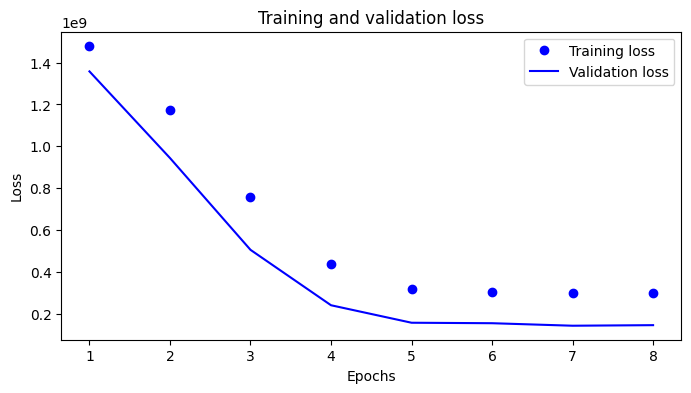

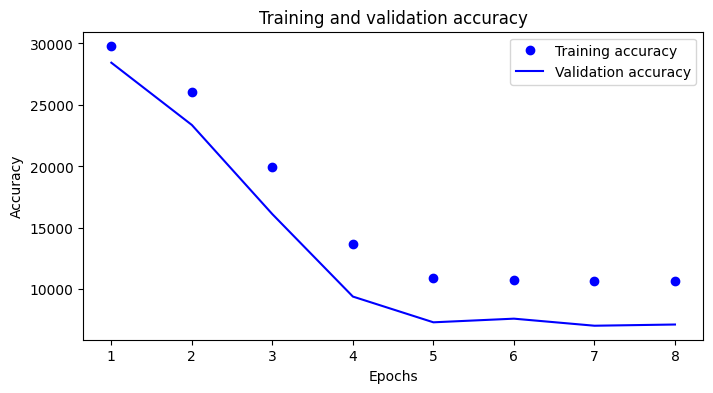

In [ ]:
# training 과정에서의 loss 및 accuracy 시각화
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['mae']
val_acc = history.history['val_mae']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
Y_test_hat = model.predict(X_test).ravel().astype(int)

10781/10781 [==============================] - 20s 2ms/step


In [ ]:
hat_s = Y_test_hat[1000:1020]
s = Y_test[1000:1020]

<Figure size 1000x600 with 0 Axes>

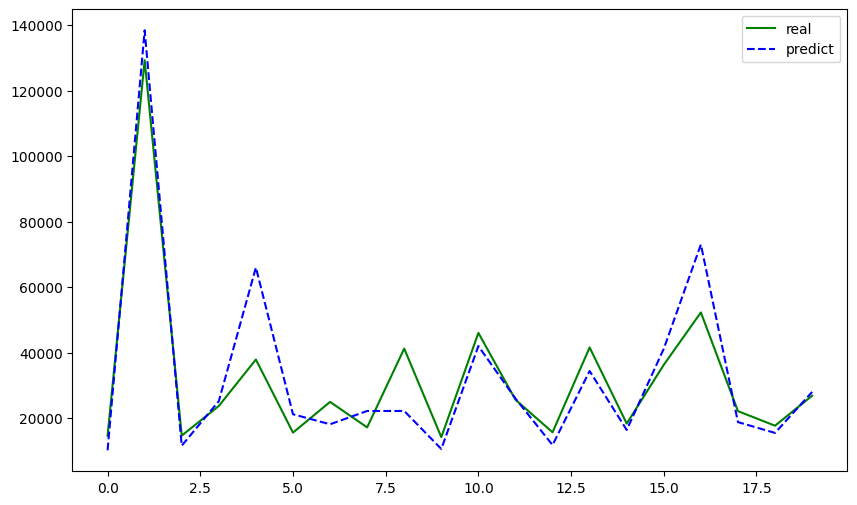

<Figure size 1000x600 with 0 Axes>

In [ ]:
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(np.arange(20), hat_s, '-',color = 'green', label='real')
plt.plot(np.arange(20), s, '--', color = 'blue', label='predict')
plt.legend()
plt.figure()

In [ ]:
hat_s = Y_test_hat[:100]
s = Y_test[:100]

<Figure size 2000x1000 with 0 Axes>

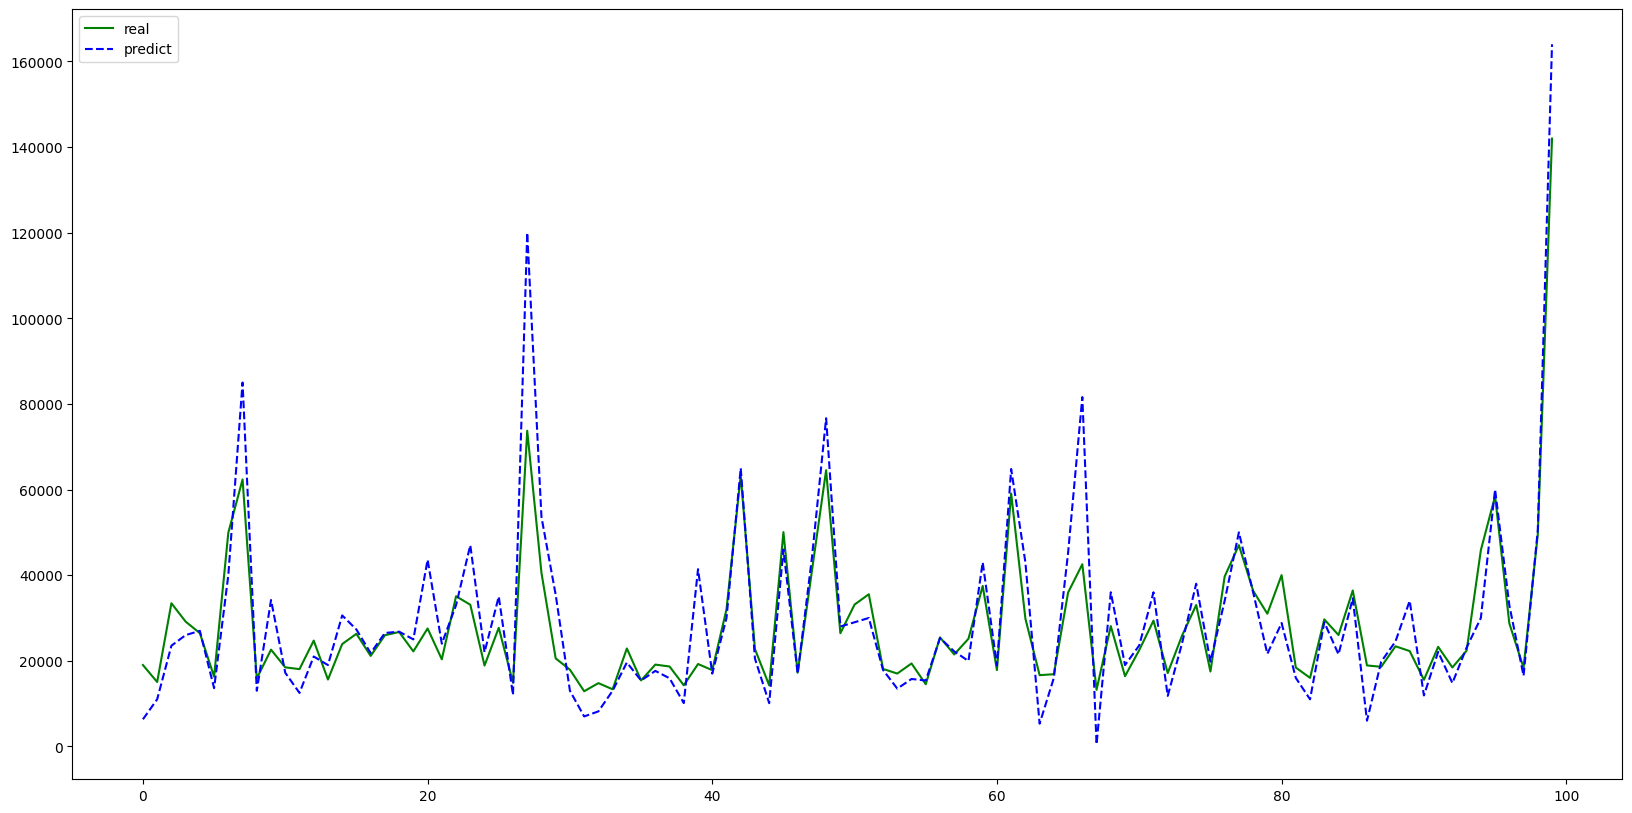

<Figure size 2000x1000 with 0 Axes>

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(np.arange(100), hat_s, '-',color = 'green', label='real')
plt.plot(np.arange(100), s, '--', color = 'blue', label='predict')
plt.legend()
plt.figure()

<Figure size 2000x1000 with 0 Axes>

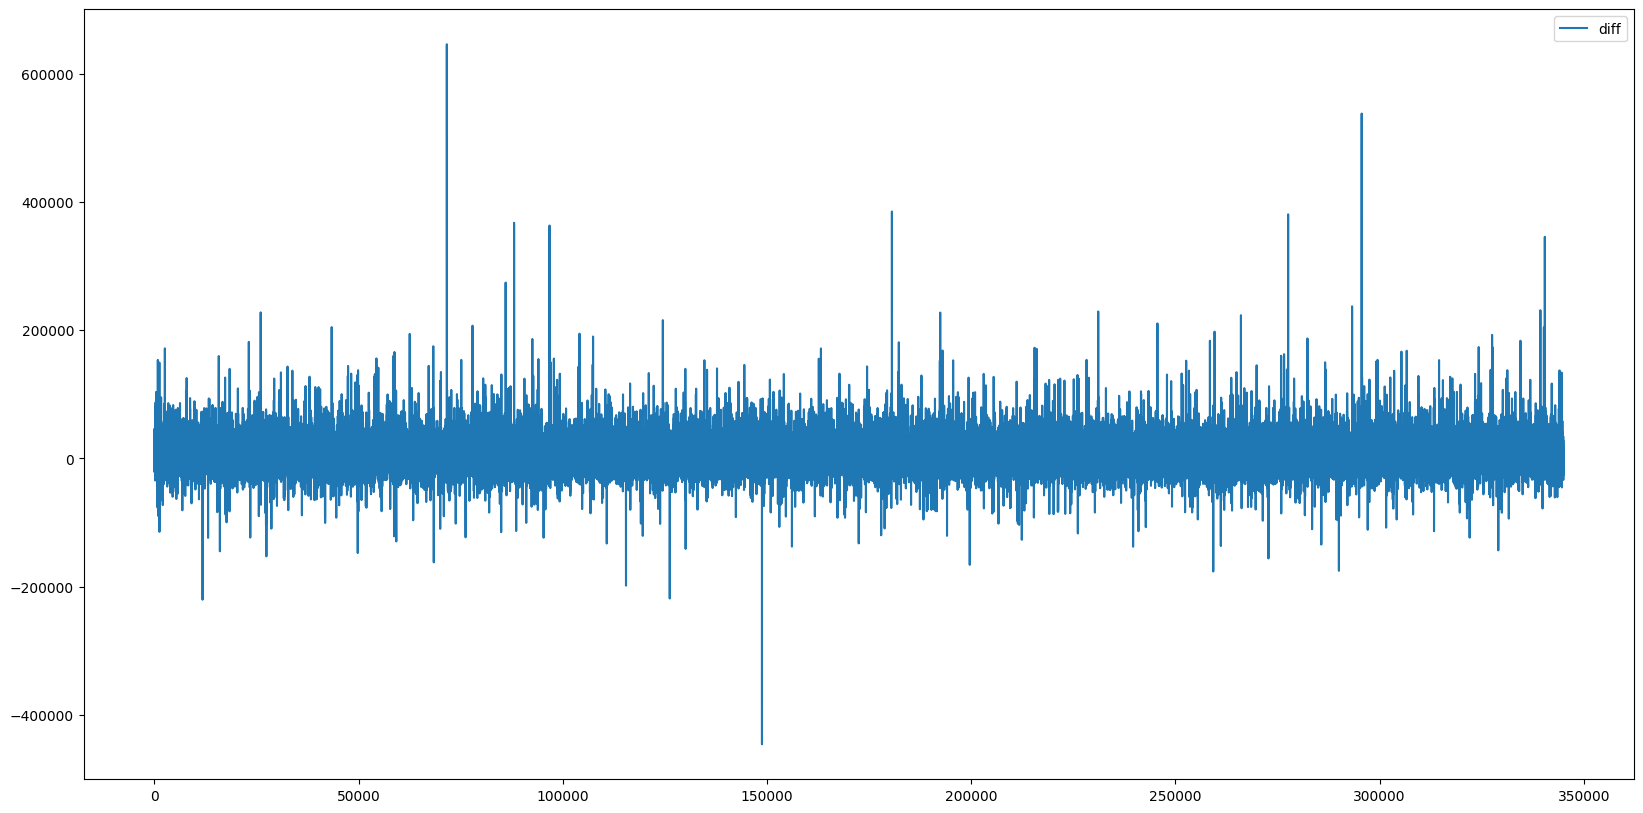

<Figure size 2000x1000 with 0 Axes>

In [ ]:
diff = Y_test - Y_test_hat

plt.rcParams["figure.figsize"] = (20,10)
plt.plot(np.arange(344979), diff, '-', label='diff')
plt.legend()
plt.figure()

<Figure size 2000x1000 with 0 Axes>

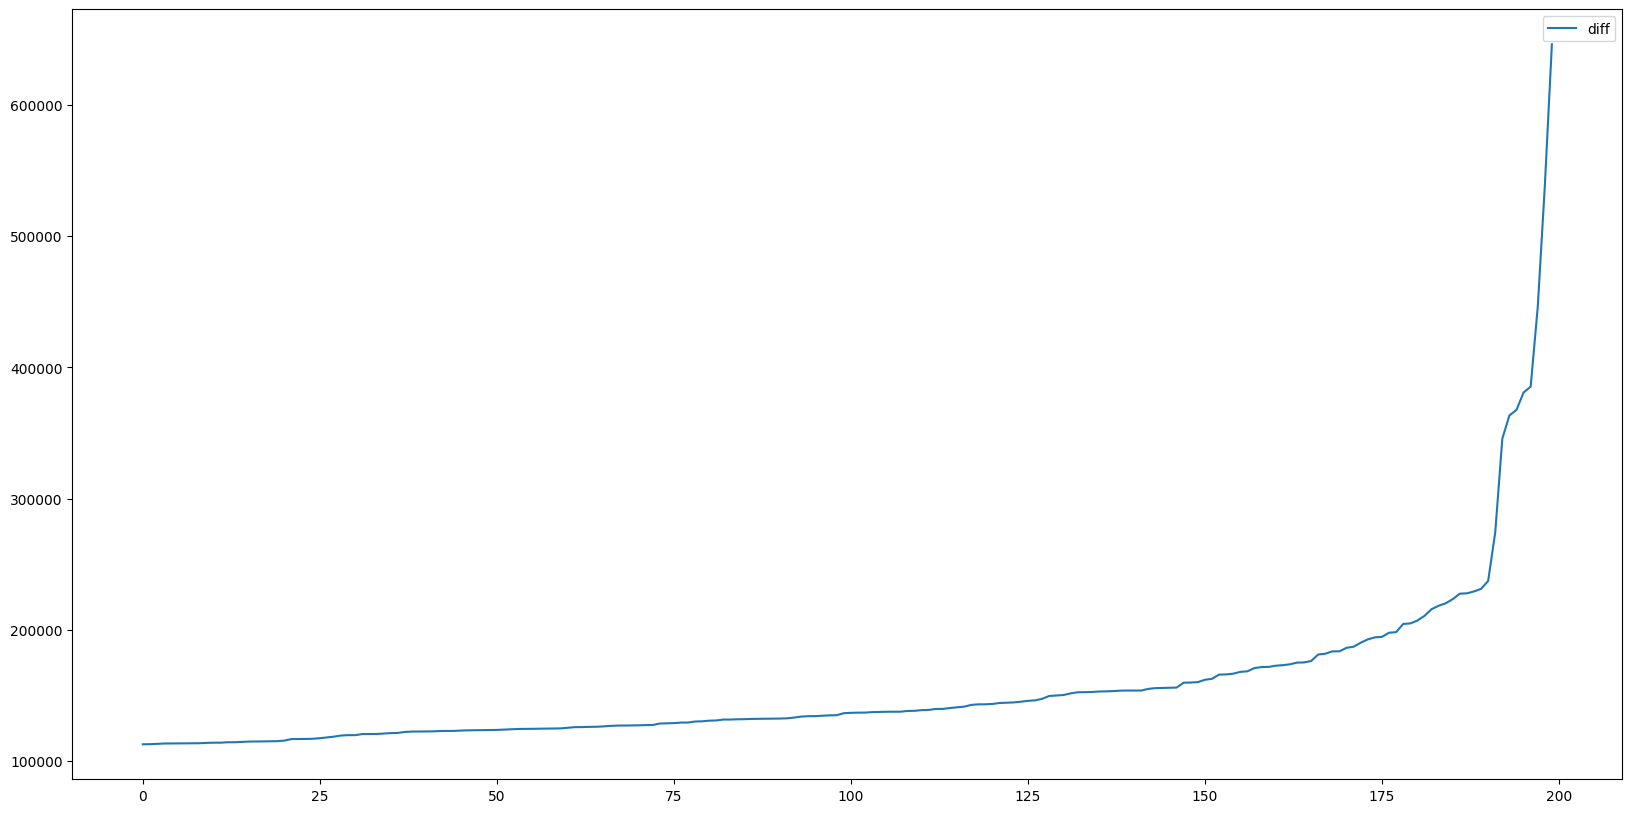

<Figure size 2000x1000 with 0 Axes>

In [ ]:
sorted_diff = np.sort(np.abs(diff))[-200:]  # 오름차순으로 정렬
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(np.arange(200), sorted_diff, '-', label='diff')
plt.legend()
plt.figure()

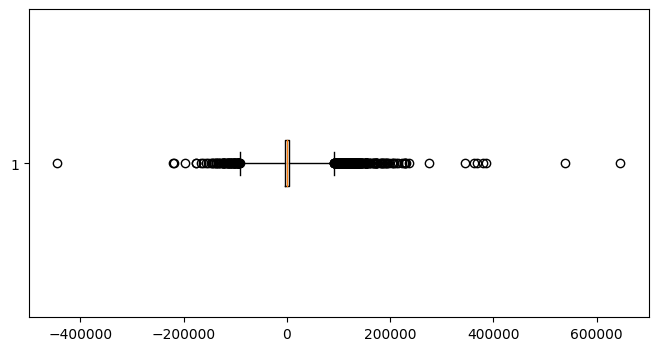

In [ ]:
plt.rcParams["figure.figsize"] = (8,4)
plt.boxplot(diff, vert=False, whis=10)
plt.show()